## Classification of X-ray images into two categories: normal lungs and pneumonia-affected lungs 
### Model: Fine-tuned CNN (ResNet-18)

### LOAD KEY LIBRARIES

In [194]:
# Import required libraries
# -------------------------
# Data loading and plotting
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data Visualization 
import matplotlib as mpimg
from PIL import Image
import seaborn as sns
# import cv2

# Train model
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Validate model
import os, random, shutil

# Evaluate model
from torchmetrics import Accuracy, F1Score, ConfusionMatrix

# Set random seeds for reproducibility
torch.manual_seed(101010)
np.random.seed(101010)
random.seed(101010)

## STEPS FOR FINE-TUNING A MODEL
1. Load & transform dataset, dataloader
2. Load pretrained model & modify only last layer
4. Train Model
5. Fine-tune Model
6. Evaluate Model

### WHY RESNET-18?
- Useful for building (very) deep neural networks because it overcomes the vanishing gradient problem.
- The vanishing gradient problem is a result of repeated multiplication of gradients during back propagation, which results in really small gradients, and earlier layer weights are barely or not updated at all.

## 1. LOAD DATA

In [8]:
import os, zipfile

# go up one level from script directory to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "data")

# check if chestxrays folder exists
chestxray_dir = os.path.join(data_dir, "chestxrays")
zip_path = os.path.join(data_dir, "chestxrays.zip")

if not os.path.exists(chestxray_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Data extracted to:", data_dir)
else:
    print("Data already exists:")

Data extracted to: C:\Users\mercy\Desktop\CODE\datacamp\Xray_Classification_PyTorch\data


### 1.2 Setting Up Data Directory

In [10]:
print(os.listdir(data_dir))

['chestxrays', 'chestxrays.zip']


In [11]:
# check folders within base folder
print(os.listdir(data_dir))

# define directories
## train
trainimages_dir = os.path.join(data_dir, 'chestxrays', 'train')
trainimages_norm_dir = os.path.join(data_dir, 'chestxrays', 'train', 'NORMAL')
trainimages_pneu_dir = os.path.join(data_dir, 'chestxrays', 'train', 'PNEUMONIA')

## test
testimages_dir = os.path.join(data_dir, 'chestxrays', 'test')
testimages_norm_dir = os.path.join(data_dir, 'chestxrays', 'test', 'NORMAL')
testimages_pneu_dir = os.path.join(data_dir, 'chestxrays', 'test', 'PNEUMONIA')

# check filenames in training directories
trainimages_norm = os.listdir(trainimages_norm_dir) 
trainimages_pneu = os.listdir(trainimages_pneu_dir)

print(f"\nFilenames for Training Normal Images: {trainimages_norm[:10]}")
print(f"\nFilenames for Training Pneumonia Images: {trainimages_pneu[:10]}")

['chestxrays', 'chestxrays.zip']

Filenames for Training Normal Images: ['IM-0213-0001.jpeg', 'IM-0235-0001.jpeg', 'IM-0245-0001.jpeg', 'IM-0249-0001.jpeg', 'IM-0269-0001.jpeg', 'IM-0273-0001.jpeg', 'IM-0276-0001.jpeg', 'IM-0289-0001.jpeg', 'IM-0295-0001.jpeg', 'IM-0302-0001.jpeg']

Filenames for Training Pneumonia Images: ['person1028_bacteria_2959.jpeg', 'person1088_bacteria_3028.jpeg', 'person1108_virus_1833.jpeg', 'person1115_virus_1840.jpeg', 'person1150_bacteria_3095.jpeg', 'person1157_virus_1937.jpeg', 'person1159_virus_1944.jpeg', 'person1171_bacteria_3118.jpeg', 'person1175_virus_1981.jpeg', 'person1176_bacteria_3124.jpeg']


In [12]:
# move some images from training to validation folder
def move_files(orig_dir, dest_dir, n=50):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    files = os.listdir(orig_dir)
    n = min(n, len(files)) # to prevent ValueError if fewer files exist
    random_files = random.sample(files, n)
    for file in random_files:
        shutil.move(os.path.join(orig_dir, file), os.path.join(dest_dir, file))

valimages_dir = os.path.join(data_dir, 'chestxrays', 'val')
valimages_pneu_dir = os.path.join(valimages_dir, 'PNEUMONIA')
valimages_norm_dir = os.path.join(valimages_dir, 'NORMAL')

# move both normal and pneumonia images
move_files(trainimages_pneu_dir, valimages_pneu_dir) 
move_files(trainimages_norm_dir, valimages_norm_dir)

In [13]:
# check filenames in VAL directories
valimages_pneu = os.listdir(valimages_pneu_dir)
valimages_norm = os.listdir(valimages_norm_dir) 

print(f"\nFilenames for Validation Pneumonia Images:\n\n{valimages_pneu[:10]}")
print(f"\nFilenames for Validation Normal Images:\n\n{valimages_norm[:10]}")


Filenames for Validation Pneumonia Images:

['person1150_bacteria_3095.jpeg', 'person1157_virus_1937.jpeg', 'person1159_virus_1944.jpeg', 'person1171_bacteria_3118.jpeg', 'person1208_bacteria_3160.jpeg', 'person1234_bacteria_3190.jpeg', 'person1337_virus_2307.jpeg', 'person1343_bacteria_3419.jpeg', 'person140_virus_285.jpeg', 'person1449_bacteria_3743.jpeg']

Filenames for Validation Normal Images:

['IM-0213-0001.jpeg', 'IM-0235-0001.jpeg', 'IM-0245-0001.jpeg', 'IM-0249-0001.jpeg', 'IM-0269-0001.jpeg', 'IM-0295-0001.jpeg', 'IM-0343-0001.jpeg', 'IM-0353-0001.jpeg', 'IM-0368-0001.jpeg', 'IM-0369-0001.jpeg']


### 1.3 Data Visualization

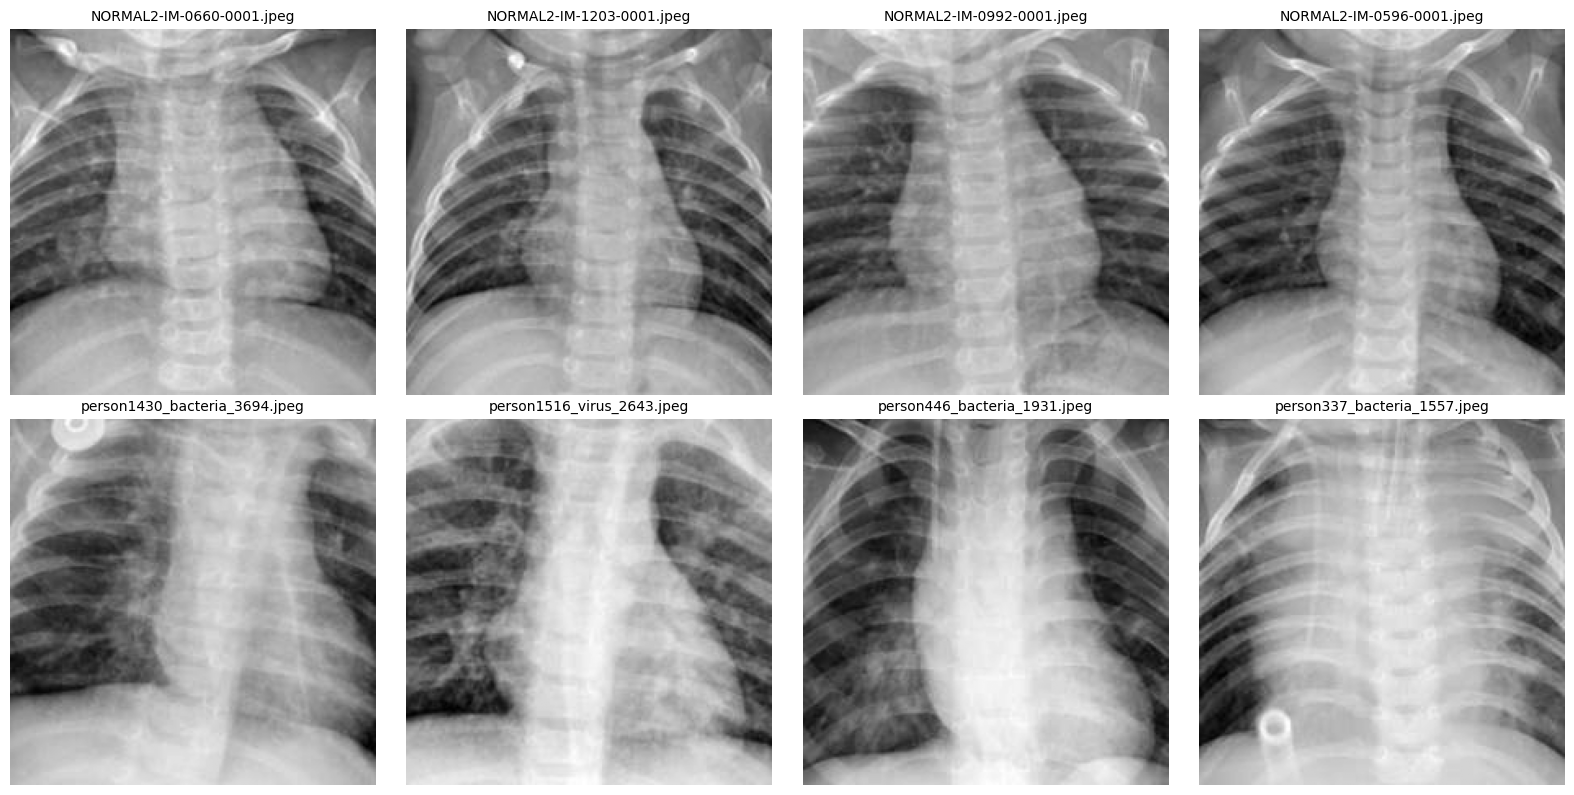

In [15]:
fig, axes = plt.subplots(2,4, figsize=(16, 8))

nxt_norm_pic = random.sample(trainimages_norm, 4)
nxt_pneu_pic = random.sample(trainimages_pneu, 4)

# Full paths
nxt_norm_pic = [os.path.join(trainimages_norm_dir, fname) for fname in nxt_norm_pic]
nxt_pneu_pic = [os.path.join(trainimages_pneu_dir, fname) for fname in nxt_pneu_pic]

# Combine for plotting
all_imgs = nxt_norm_pic + nxt_pneu_pic

for ax, img_path in zip(axes.flatten(), all_imgs):
  imgs = Image.open(img_path)
  ax.imshow(imgs, cmap = 'gray')
  ax.set_title(os.path.basename(img_path), fontsize=10)
  ax.axis('off')
    
plt.tight_layout()
plt.show()

Note: color is not relevant for differentiation; shapes, edges, and structural features are sufficient for detecting anomalies, so grayscale images are used.

Look at the difference between normal and diseased

In [18]:
# examine the difference between pneumonia and normal images
# select random image in training normal and pneumonia directories 
normal_path = os.path.join(trainimages_norm_dir, random.choice(os.listdir(trainimages_norm_dir)))
pneu_path = os.path.join(trainimages_pneu_dir, random.choice(os.listdir(trainimages_pneu_dir)))

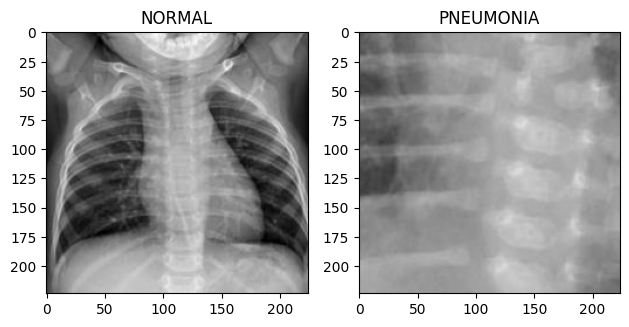

In [19]:
# plot normal and pneumonia image
img_norm = Image.open(normal_path)
img_pneu = Image.open(pneu_path)

# plot side by side
fig, axes = plt.subplots(1,2)

# normal x-ray
axes[0].imshow(img_norm, cmap = "gray")
axes[0].set_title("NORMAL")

# pneumonia x-ray
axes[1].imshow(img_pneu, cmap = "gray")
axes[1].set_title("PNEUMONIA")

plt.tight_layout()
plt.show()

### 1.4 Setting Up Dataloader

In [21]:
# Define the transformations to apply to the images for use with ResNet-18
transform_mean = [0.485, 0.456, 0.406]
transform_std =[0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=transform_mean, std=transform_std)])

# Apply the image transforms
train_df = ImageFolder(trainimages_dir, transform=transform)
val_df = ImageFolder(valimages_dir, transform=transform)
test_df = ImageFolder(testimages_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_df, batch_size=len(train_df) // 2, shuffle=True)
test_loader = DataLoader(test_df, batch_size=len(test_df), shuffle=True)
val_loader = DataLoader(val_df, batch_size=len(val_df)) 

> Shuffling for randomization and for better model generalization. <br>
> Splitting batch size in two to speed up training. Common batch sizes are 32, 64, 128. <br>
> Notes: mean and standard deviation calculated for each color channel (R,G,B)

In [23]:
# Check image details
image, label = train_df[0]
print(f"Image size: {image.size()}, Label: {label}]")

for images, labels in train_loader:
    print(images.size(), labels.size())

Image size: torch.Size([3, 224, 224]), Label: 0]
torch.Size([100, 3, 224, 224]) torch.Size([100])
torch.Size([100, 3, 224, 224]) torch.Size([100])


In [24]:
# double-check
image, label = val_df[0]
print(f"Image size: {image.size()}, Label: {label}]")

for images, labels in val_loader:
    print(images.size(), labels.size())

Image size: torch.Size([3, 224, 224]), Label: 0]
torch.Size([100, 3, 224, 224]) torch.Size([100])


> Notes:
>- Output explanation: (150) number of images; (3) number of color channels; (224, 224) -dimensions (height & width) <br>
>- ResNet18 accepts 224 x 224 images 

### 2. LOAD AND MODIFY (INSTANTIATE) PRETRAINED MODEL

In [27]:
# instantiate model
# load pretrained model: resnet18 
resnet18 = models.resnet18(weights="IMAGENET1K_V1")
for param in resnet18.parameters():
    param.required_grad = False
        
# modify just the last layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

`Transfer learning:` 
freezing all layers 
-     for param in resnet18.parameters():
          param.requires_grad = False  # Freeze all layers
      resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # New classifier
`Fine-tuning:` 
for freezing some, but not all, layers
-     for name, param in resnet18.named_parameters():
          if "layer4" in name or "fc" in name:  # Unfreeze last layers
              param.requires_grad = True
          else:
              param.requires_grad = False  # Freeze others

### 3. DEFINE TRAINING AND VALIDATION FUNCTION

In [97]:
# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on GPU: {train_on_gpu}')

Train on GPU: False


In [49]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")

In [164]:
# Training function
def train(model, 
          train_loader, 
          criterion, 
          optimizer):
    
    """
    Trains a PyTorch model 

    Args:
        model: the PyTorch model
        train_loader: DataLoader for training data
        criterion: loss function
        optimizer: optimizer
        #device: cpu or gpu
    """
    model.train()
    running_loss = 0.0
    running_acc = 0

    for images, labels in train_loader:
        # images, labels = images.to(device).float(), labels.to(device).float()

        # Reset gradients
        optimizer.zero_grad()
        
        # labels have the same dimensions as outputs
        labels = labels.float().unsqueeze(1) 
        
        # Forward pass
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5 # binary classification
        loss = criterion(outputs, labels) # compare output to ground truth

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        running_acc += torch.sum(preds == labels)

    train_loss = running_loss / len(train_df)
    train_acc = running_acc.double() / len(train_df)

    return train_loss, train_acc.item()

# Validation function
def val(model, val_loader, criterion, device, num_epochs):
     
    """
    Validates a PyTorch model 

    Args:
        model: the PyTorch model
        train_loader: DataLoader for training data
        criterion: loss function
        optimizer: optimizer
        #device: cpu or gpu
    """

    model.eval()
    running_loss = 0.0
    running_acc = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # images, labels = images.to(device).float(), labels.to(device).float()
            labels = labels.float().unsqueeze(1) 
            outputs = model(images)
            preds = torch.sigmoid(outputs).round()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels)

    val_loss = running_loss / len(val_df)
    val_acc = running_acc.double() / len(val_df)

    return val_loss, val_acc

# Full training + validation loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc = val(model, val_loader, criterion, epoch, num_epochs)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, train_accs, val_losses, val_accs
    

### 4. RUN FINE-TUNEDMODEL

#### 4.1 Loss Function & Optimizer 
> `Loss Function:` measures prediction's deviation from the ground truth 
  >- most common: cross entropy loss
  >- others include: mse, BCEWithLogitsLoss (binary cross entropy with logits - combination of sigmoid & binary cross-entropy loss together)

> `Optimizer:` algorithm that updates weights and bias in order to minimize loss
  >- most common: SGD (stochastic gradient descent) - better for fine-tuning 
  >- others include: Adam (adapative moment estimation) - earlier layers, faster convergence, might lead to overfitting

In [166]:
# specify model
# run model on GPU if available
model = resnet18
# model.to(device)  # Sending model to device

# specify loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    resnet18.fc.parameters(), # only last layer is optimized
    lr=0.001
)  

In [168]:
# train model 
train_losses, train_accs, val_losses, val_accs = train_model(
    model, 
    train_loader, 
    val_loader,
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=10
)

Epoch [10/10] Training Loss: 0.2081, Training Acc: 0.9450
Epoch [10/10] Val Loss: 0.3530, Val Acc: 0.8600


In [170]:
# compare prediction to label
outputs = model(images)
pred_probs = torch.sigmoid(outputs)
print(pred_probs[:10], 
      labels[:10])

tensor([[0.7334],
        [0.3470],
        [0.7703],
        [0.9587],
        [0.7708],
        [0.9802],
        [0.4024],
        [0.8662],
        [0.9391],
        [0.9804]], grad_fn=<SliceBackward0>) tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1])


In [206]:
# loss and Accuracy Plots
def plot_train_val_curves(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # Loss curves
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curves
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Val Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

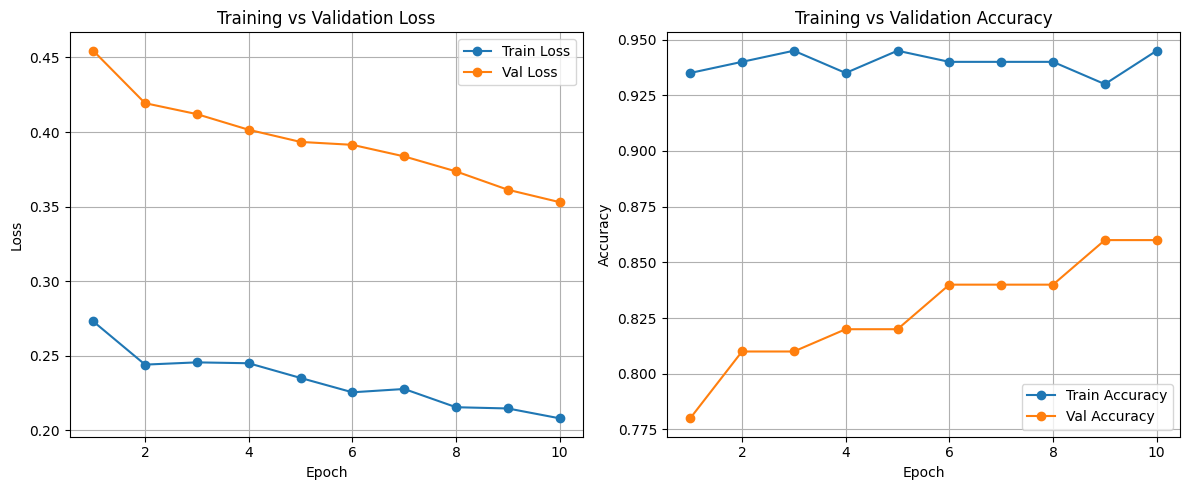

In [208]:
plot_train_val_curves(train_losses, train_accs, val_losses, val_accs)

### 5. MODEL EVALUATION

In [196]:
# Set model to evaluation mode
model.eval()

# Initialize metrics for accuracy and F1 score
accuracy_metric = Accuracy(task="binary")
f1_metric = F1Score(task="binary")
conf_matrix_metric = ConfusionMatrix(task="binary")

# Create lists store all predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for images, labels in test_loader:
    # Forward pass
    outputs = model(images)
    preds = torch.sigmoid(outputs).round()  # Round to 0 or 1

    # Extend the lists with predictions and labels
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.unsqueeze(1).tolist())

    # Convert lists back to tensors
    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    # Calculate accuracy and F1 score
    test_acc = accuracy_metric(all_preds, all_labels).item()
    test_f1 = f1_metric(all_preds, all_labels).item()
    conf_matrix = conf_matrix_metric(all_preds, all_labels)

print(f"\nTest accuracy: {test_acc:.3f}\nTest F1-Score: {test_f1:.3f}")


Test accuracy: 0.770
Test F1-Score: 0.810


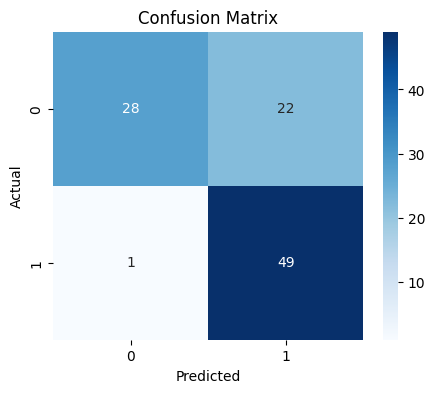

In [197]:
# confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

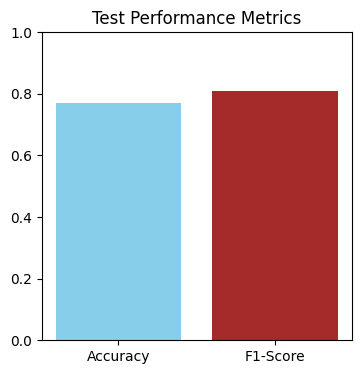

In [198]:
# metrics bar plot
plt.figure(figsize=(4,4))
plt.bar(['Accuracy', 'F1-Score'], [test_acc, test_f1], color=['skyblue', 'brown'])
plt.ylim(0,1)
plt.title('Test Performance Metrics')
plt.show()